****Part I**** - Use this
[dataset](https://www.dropbox.com/s/pan6mutc5xj5kj0/trainPart1.zip) to
train a CNN. Use no other data source or pretrained networks, and
explain your design choices during preprocessing, model building and
training. Also, cite the sources you used to borrow techniques. A test
set will be provided later to judge the performance of your classifier.
Please save your model checkpoints.

****Dataset Overview****

The dataset consists of 62 classes, with 40 samples of each sample.
Classes - \[0-9, A-Z, a-z\] Total number of images - 62\*40 = 2480
images

torch.Size([900, 1200, 3])


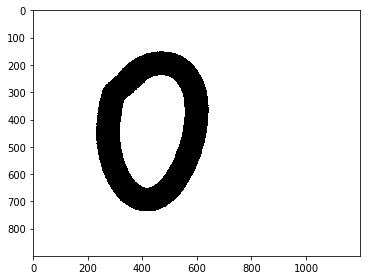

In [2]:
# Image details
import torch
from skimage import io

img = io.imread("train/Sample001/img001-001.png")
io.imshow(img)
print(torch.tensor(img).shape)


****Establishing baselines****

In solving this task, my first approach was to establish a baseline
using a barebones CNN with minimal features. The outcome of this subtask
would be to assess performance on the dataset and provide a baseline for
future measurements. Pytorch and the Pytorch-lightning framework are
used in developing the neural network for this task. Pytorch Lightning
provides a high level API in developing the networks, while organizing
the code and making it easier to modify.

In [ ]:
import os
from typing import Optional

import torch
from skimage import io
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl


****Data Loading****

For handling all tasks relating to data and its loading, Pytorch
Lightning provides `LightningDataModule` [1], which wraps Pytorch's
`Dataset` and `DataLoader` abstractions, and provides a single interface
to access data.

The image paths and the classes to which they belong to are loaded from
the provided base directory. Initially, the images themselves were
loaded into memory instead of their filepaths, but my system was unable
to load the entrie dataset due to lack of memory. Thus the paths are
loaded, and during training, the images will be loaded using these
paths.

Cross-entropy is widely used as a loss function when optimizing
classification models [2], allowing us to quantify the difference
between the target probability distribution and the distribution of the
model's output.

In PyTorch, CrossEntropyLoss [3] expects *a list of class indices \[0,
C-1\]*, which means the target vector of classnames must be encoded into
a vector of integers. sklearn's `LabelEncoder()` transforms the target
vector into the appropriate encoding.

Finally, `train_test_split` is used to split the dataset into training,
validation and testing sets according to an 80-10-10 split.

[1] [LightningDataModule](https://pytorch-lightning.readthedocs.io/en/latest/extensions/datamodules.html)

[2] [A Gentle Introduction to Cross-Entropy for Machine
Learning](https://machinelearningmastery.com/cross-entropy-for-machine-learning/)

[3] [PyTorch
CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

In [ ]:
class NumbersAndLettersDataset(Dataset):
    ''' Dataset for numbers and letters. '''
    def __init__(self, input_data, target, transform=None):
        self.input_data = input_data
        self.target = target
        self.transform = transform

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        img = torch.tensor(io.imread(self.input_data[idx]))
        img = img.permute(2, 0, 1) # Reshape to bring channels to first index
        return (img, self.target[idx])

class NumbersAndLettersModule(pl.LightningDataModule):
    ''' DataModule for loading of dataset. '''
    def __init__(self, data_dir, batch_size):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.nal_train = None
        self.nal_test = None
        self.nal_val = None

    def setup(self, stage: Optional[str] = None):
        if stage in (None, 'fit'): # Create all datasets
            img_dataset, img_classes = self.load_data(self.data_dir)
            print("Data loaded from disk")

            # Prepare target using Label Encoding
            le = LabelEncoder()
            le.fit(img_classes)
            img_classes = torch.tensor(le.transform(img_classes))

            dataset = NumbersAndLettersDataset(img_dataset, img_classes)

            # Creating train, test, val datasets according to an 80-10-10 split
            self.nal_train, self.nal_test = train_test_split(dataset, test_size=0.1)
            self.nal_train, self.nal_val = train_test_split(self.nal_train, test_size=0.1)

    def train_dataloader(self):
        return DataLoader(self.nal_train, batch_size=self.batch_size, num_workers=4)

    def val_dataloader(self):
        return DataLoader(self.nal_val, batch_size=self.batch_size, num_workers=4)

    def test_dataloader(self):
        return DataLoader(self.nal_test, batch_size=self.batch_size, num_workers=4)

    def load_data(self, img_dir):
        ''' Load image_paths and their classes from disk. '''
        dataset = []
        classes = []
        for folder in os.listdir(img_dir):
            img_class = int(folder[-2:]) # Extract last 2 digits of folder name
            if img_class < 11:
                img_class = str(img_class - 1) # 0-9
            elif img_class < 37:
                img_class = chr(img_class + 54) # A-Z
            else: img_class = chr(img_class + 60) # a-z
            for img in os.listdir(os.path.join(img_dir, folder)):
                img_path = os.path.join(img_dir, folder, img)
                dataset.append(img_path)
                classes.append(img_class)
        return dataset, classes

SEED = 42 # Set a global seed for reproducible results
BATCH_SIZE = 4
BASE_DIR = "train"

INPUT_DIM = torch.tensor([3, 900, 1200])

pl.utilities.seed.seed_everything(SEED)

# Create DataModule to handle loading of dataset
data_module = NumbersAndLettersModule(BASE_DIR, BATCH_SIZE)


In building the CNN, I decided to implement a simple CNN to understand
what the baseline performance looks like. Thus, the design decision in
building this CNN were guided by using standard domain knowledge without
additional features.

**Network Architecture**

In designing the network, I referred to CS231, Stanford's course on CNNs
[1], in which they present a stacked CONV-RELU followed by POOL layers
as the most common architecture. I have opted for a similar design of 4
repeating CONV-POOL-RELU stacks. After this, the output of the 4th stack
is flattened into a 1D vector and then fed to three fully connected
layers, gradually bringing down the dimensionality of the vector to that
of the number of output classes.

In PytorchLightning, the `LightningModule` is used to build neural nets,
and it exposes various methods to simplify the process.

1.  `forward` -\> The forward pass.
2.  `configure_optimizers` -\> Return the optimizer to be used in
    training
3.  `{training, validation, test}_step` -\> These functions expose the
    training, validation and test loops respectively. In these
    functions, the input is propagated through the network, following
    which the cross entropy loss is computed.

*Loss* -\> As common in classification tasks, Cross Entropy Loss is
used. *Optimizer* -\> Again, the standard choice is the Adam optimizer
and it has been selected.

**Logging**

I consider logging very important, especially while experimenting with
different architectures, it is important to have a baseline stored so
future changes can be compared against it. For logging, I have used the
Weights and Biases logger integrated into Pytorch Lightning. It allows
for live tracking on their website and export of results.

[1] [CS231N](https://cs231n.github.io/convolutional-networks/)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class NumbersAndLettersCNN(pl.LightningModule):
    ''' Implementation of CNN to detect numbers and letters. '''
    def __init__(self, input_dim, output_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(input_dim[0], 16, 6)
        self.conv2 = nn.Conv2d(16, 64, 6)
        self.conv3 = nn.Conv2d(64, 128, 6)
        self.conv4 = nn.Conv2d(128, 256, 6)
        self.pool = nn.MaxPool2d(3)
        self.fc1 = nn.Linear(256 * 8 * 12, 4096)
        self.fc2 = nn.Linear(4096, 256)
        self.fc3 = nn.Linear(256, output_classes)

    def forward(self, x):
        ''' Forward pass '''
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self(x.float())
        loss = F.cross_entropy(output, y.long())
        self.log('train_loss', loss, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self(x.float())
        loss = F.cross_entropy(output, y.long())
        acc = torch.mean((torch.argmax(output, axis=1) == y).float())
        self.log_dict({'val_loss': loss, 'val_acc': acc})

    def test_step(self, batch, batch_idx):
        x, y = batch
        output = self(x.float())
        loss = F.cross_entropy(output, y.long())
        acc = torch.mean((torch.argmax(output, axis=1) == y).float())
        self.log_dict({'test_loss': loss, 'test_acc': acc})

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

MODEL_NAME = 'numbers-and-letters-cnn'

INPUT_DIM = torch.tensor([3, 900, 1200])
OUTPUT_CLASSES = 62

# Train and test model

model = NumbersAndLettersCNN(INPUT_DIM, OUTPUT_CLASSES)

# Log metrics to WandB
wandb_logger = pl.loggers.WandbLogger(save_dir='logs/',
                                        name="%s.pth" %MODEL_NAME,
                                        project='midas-task-2')
trainer = pl.Trainer(gpus=1, logger=wandb_logger, max_epochs=1)
trainer.fit(model, data_module)
trainer.test(model=model, datamodule=data_module)


When I started training the model, I quickly ran into Out-of-Memory
exceptions. I am training on a laptop with 4GB VRAM, and the network I
had initially designed was too large for my machine. My first approach
was to reduce the batch size from 64 progressively until 4.

Even this was not sufficient for the network to run on my GPU and my
next approach was to more aggressively use the Convolution and Pooling
layers. The Pooling Layer's kernel size was increased to (3,3) from
(2,2) to reduce the input vector size faster and similarly the size of
the kernel of the Conv2D layers was also increased from (5,5) to (6,6),
convolving over a larger window each time.

With these enhancements, I was able to run the network on my machine,
complete a training loop on one epoch, fix the bugs and complete the
training pipeline.